In [19]:
## 参考：https://chatgpt.com/c/68ccb63d-d74c-8322-8d27-43589b78aa10
from typing import TypedDict, Optional, Literal
from typing_extensions import Annotated
import uuid

from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt

# 假设的发布工具
def publish_article_tool(article_id: str, summary: str) -> str:
    return f"Article {article_id} published with summary: {summary}"

# 状态结构
class State(TypedDict, total=False):
    article_id: str
    article_text: str
    summary: str
    summary_reviewed: bool
    publish_status: Optional[str]
    rejected: bool
    user_feedback: Optional[str]
    publish_decision: Optional[str]   # 用来保存审核决策

# 节点1: 生成摘要
def generate_summary(state: State) -> State:
    summary = f"自动生成的摘要（基于文章内容: {state['article_text'][:50]}...）"
    return {"summary": summary, "summary_reviewed": False}

# 节点2: 人类审核摘要
def review_summary(state: State) -> State:
    edited_summary = interrupt({"summary_to_review": state["summary"]})
    return {"summary": edited_summary, "summary_reviewed": True}

# 节点3: 决定是否发布
def decide_publish(state: State) -> State:
    decision = interrupt({
        "question": "审核过的摘要如下，请决定是否发布：",
        "summary": state["summary"]
    })
    return {"publish_decision": decision.strip().lower()}

# 路由函数：根据决策选择分支
def decide_route(state: State) -> Literal["publish", "reject_publish"]:
    d = (state.get("publish_decision") or "").strip().lower()
    if d in ("yes", "approve", "ok", "publish"):
        return "publish"
    return "reject_publish"

# 节点4: 发布文章
def publish(state: State) -> State:
    pub_status = publish_article_tool(state["article_id"], state["summary"])
    return {"publish_status": pub_status}

# 节点5: 发布后收集反馈
def post_publish_feedback(state: State) -> State:
    feedback = interrupt({
        "feedback_request": "文章已发布，您是否满意？",
        "publish_status": state.get("publish_status", "")
    })
    return {"user_feedback": feedback}

# 节点6: 拒绝发布
def reject_publish(state: State) -> State:
    return {"rejected": True}

# 节点7: 结束
def done(state: State) -> State:
    print("流程完成。最终状态：", state)
    return state

# 构建图
def build_graph():
    builder = StateGraph(State)

    builder.add_node("generate_summary", generate_summary)
    builder.add_node("review_summary", review_summary)
    builder.add_node("decide_publish", decide_publish)
    builder.add_node("publish", publish)
    builder.add_node("post_publish_feedback", post_publish_feedback)
    builder.add_node("reject_publish", reject_publish)
    builder.add_node("done", done)

    # 边
    builder.add_edge(START, "generate_summary")
    builder.add_edge("generate_summary", "review_summary")
    builder.add_edge("review_summary", "decide_publish")

    # 条件边：根据决策走不同分支
    builder.add_conditional_edges("decide_publish", decide_route, {
        "publish": "publish",
        "reject_publish": "reject_publish",
    })

    builder.add_edge("publish", "post_publish_feedback")
    builder.add_edge("post_publish_feedback", "done")
    builder.add_edge("reject_publish", "done")

    checkpointer = InMemorySaver()
    return builder.compile(checkpointer=checkpointer)

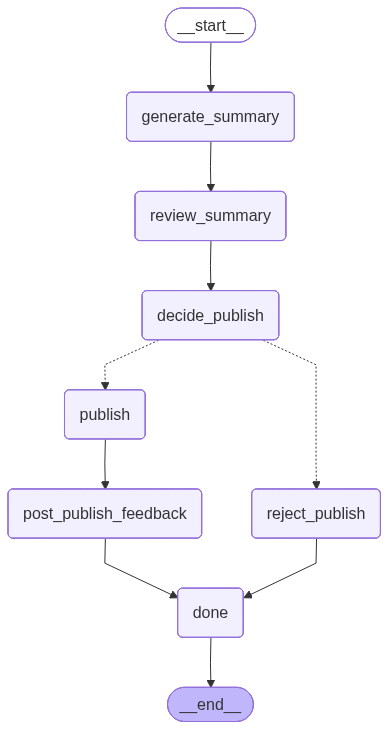

In [20]:
from IPython.display import Image, display
app = build_graph()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [28]:
def run_flow():
    graph = build_graph()
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}

    init_state = {
        "article_id": "art123",
        "article_text": "这是用户提交的一篇很长的文章内容……"
    }

    # 第一次运行 -> 会在 review_summary 中断
    result = graph.invoke(init_state, config=config)
    print("第一次中断（审核摘要）：", result.get("__interrupt__"))

    # 模拟人工修改摘要
    result2 = graph.invoke({"summary": "这是人工修改后的摘要版本。"}, config=config)
    print("第二次中断（是否发布）：", result2.get("__interrupt__"))

    # 模拟人工批准
    result3 = graph.invoke({"publish_decision": "approve"}, config=config)
    print("第三次中断（发布后反馈）：", result3.get("__interrupt__"))

    # 模拟人工反馈
    result4 = graph.invoke({"user_feedback": "不太满意，下次摘要再简短一些。"}, config=config)
    print("最终状态：", result4)



In [29]:
if __name__ == "__main__":
    run_flow()

第一次中断（审核摘要）： [Interrupt(value={'summary_to_review': '自动生成的摘要（基于文章内容: 这是用户提交的一篇很长的文章内容……...）'}, id='e72da33c0ac984112c38d3873205ef1a')]
第二次中断（是否发布）： [Interrupt(value={'summary_to_review': '自动生成的摘要（基于文章内容: 这是用户提交的一篇很长的文章内容……...）'}, id='e7a454550ac1dbce5944146b77ac9d8b')]
第三次中断（发布后反馈）： [Interrupt(value={'summary_to_review': '自动生成的摘要（基于文章内容: 这是用户提交的一篇很长的文章内容……...）'}, id='9e3ab763213596439454029e86fa566c')]
最终状态： {'article_id': 'art123', 'article_text': '这是用户提交的一篇很长的文章内容……', 'summary': '自动生成的摘要（基于文章内容: 这是用户提交的一篇很长的文章内容……...）', 'summary_reviewed': False, 'user_feedback': '不太满意，下次摘要再简短一些。', 'publish_decision': 'approve', '__interrupt__': [Interrupt(value={'summary_to_review': '自动生成的摘要（基于文章内容: 这是用户提交的一篇很长的文章内容……...）'}, id='fecf8264a26bd1e3f599a83c6aeabcdd')]}
